**Предыдущий успешный результат на 12 скорости оказался не стабильным. На текущем варианте проведено много испытаний с стабильно положительным результатом. При этом есть недостаток в виде рывков на проходе дуги.**

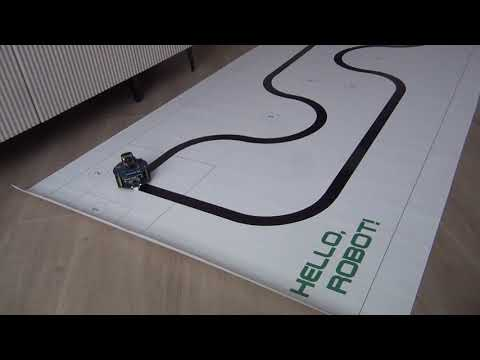

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Tx7ivebcC-c', width=800, height=455)

#### Исходные данные

* Ограничение максимального выхода 30
* KP = 0.3, KD = 0.3, KI = 0, скорость = 12, sleep = 10 мкс

#### Что пробоверено и не привело к улучшениям:
* Попробовать уменьшить KP и KD

#### Что не проверено:

* Обрабатывать отрицательный PID при приближении к нулю
* Сделать более точную калибровку
* Выставить правильный период изменения сейчас dt всегда 1
* Не усиливать P значением D, а только гасить 
* Получать значение по среднему из трех измерений


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loader import load_data 
sys.path.append("../src")
from alphabot.pid_module import PidController

In [3]:
data = load_data('./data/7_stable_follow_on_12_speed.log')
sensor0=data['sensor0']
sensor1=data['sensor1']
sensor2=data['sensor2']
sensor3=data['sensor3']
sensor4=data['sensor4']
left_pid_out = data['left_pid_out']
right_pid_out = data['right_pid_out']
tm = data['tm']
actual_right_pid_out = []
print(len(tm))
dt_in_ms = np.diff(tm)/1_000_000
print(dt_in_ms)


6800
[2.008593 1.932149 1.822519 ... 1.876834 1.508223 1.48063 ]


### Сделаем анализ распределения времени между итерациями. В каждой итерации замер и формирование управляющего воздействия.

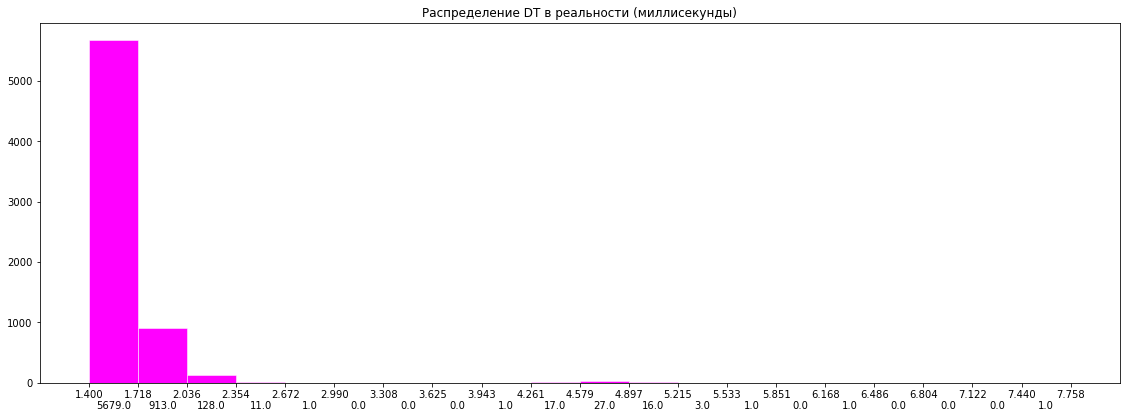

In [4]:
range_len = 6800
start = 0
end = start + range_len
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])

counts, bins, patches = ax.hist(dt_in_ms, bins=20, linewidth=0.5, edgecolor="white", color = 'magenta')
ax.set_xticks(bins)
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'), xytext=(0, -18), textcoords='offset points', va='top', ha='center')
ax.set_title("Распределение DT в реальности (миллисекунды)")
plt.show()

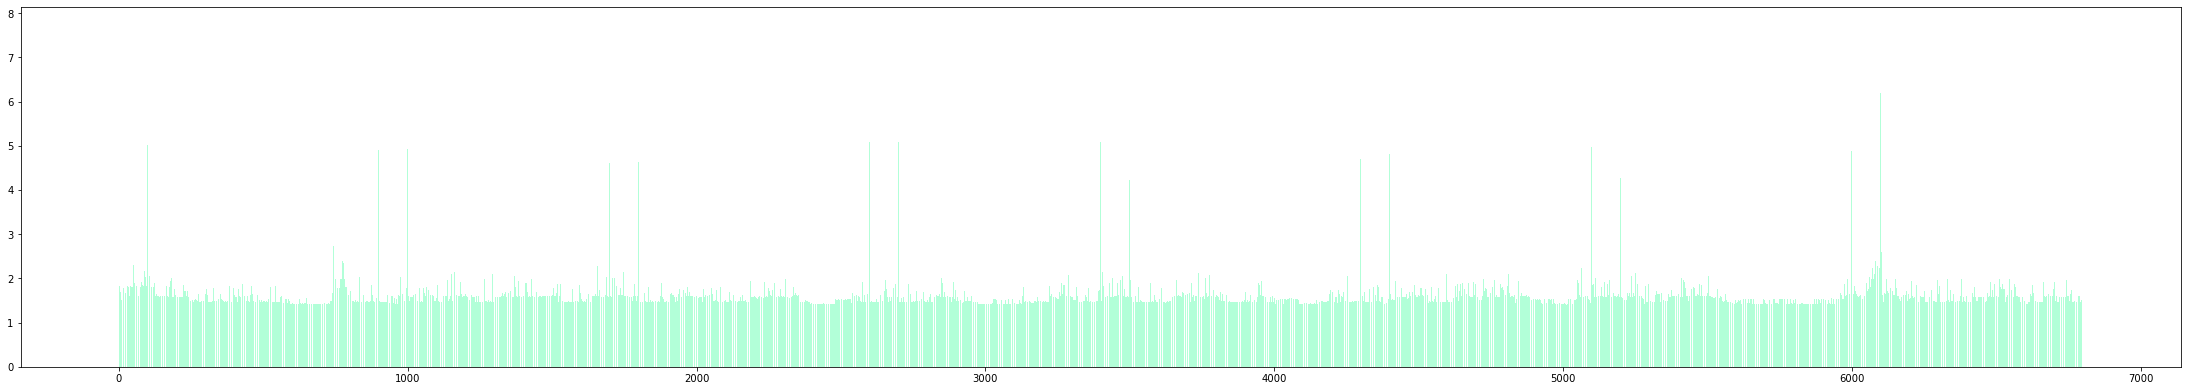

In [5]:
fig = plt.figure(figsize=(30, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(0,range_len-1,1), dt_in_ms[start:end], alpha = 0.3, color = 'springgreen')
plt.show()

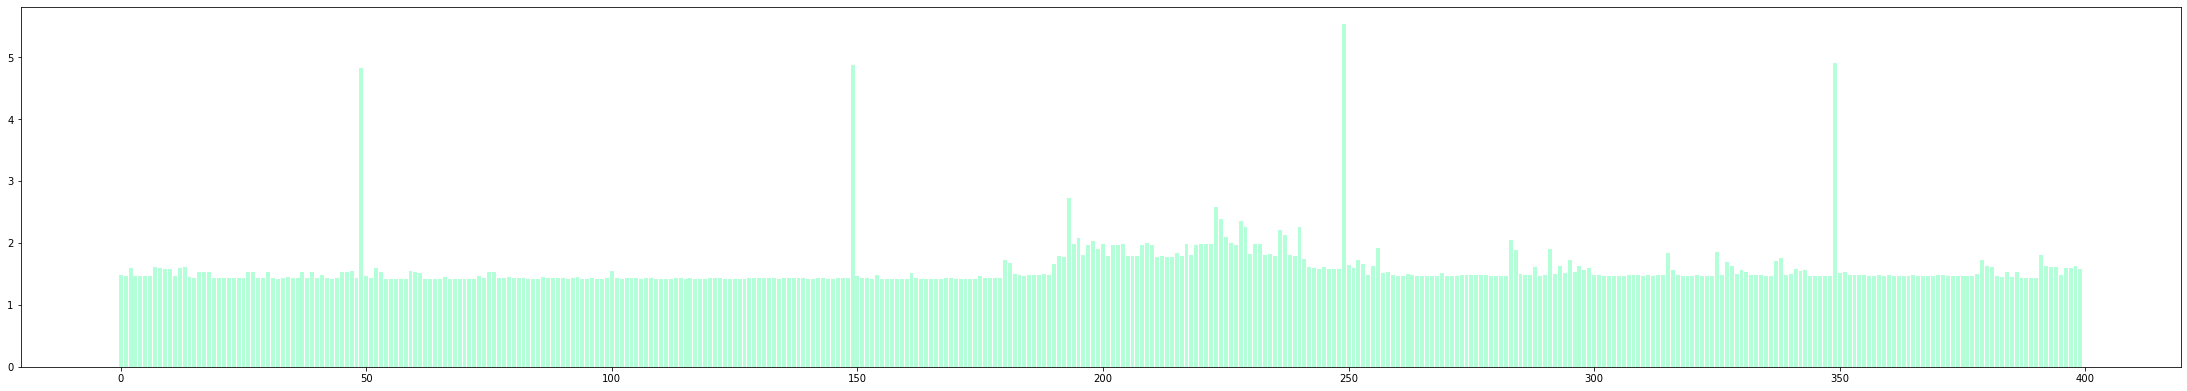

In [6]:
fig = plt.figure(figsize=(30, 5))
ax = fig.add_axes([0,0,1,1])
range_len = 400
start = 550
end = start + range_len
ax.bar(np.arange(0,range_len,1), dt_in_ms[start:end], alpha = 0.3, color = 'springgreen')
plt.show()

На диаграмме распределения видно, что в основном измерения проходят от 1,4 до 2,5 миллисекунд. На временной диаграмме видно, что периодичеки возникают единичные задержки до 5 миллисекунд. Задержки возникают каждые 100 измерений. Буфер для метрик установлен в 100. Задержки возникают при записи метрик на диск.

### Проведем анализ прохода по линии

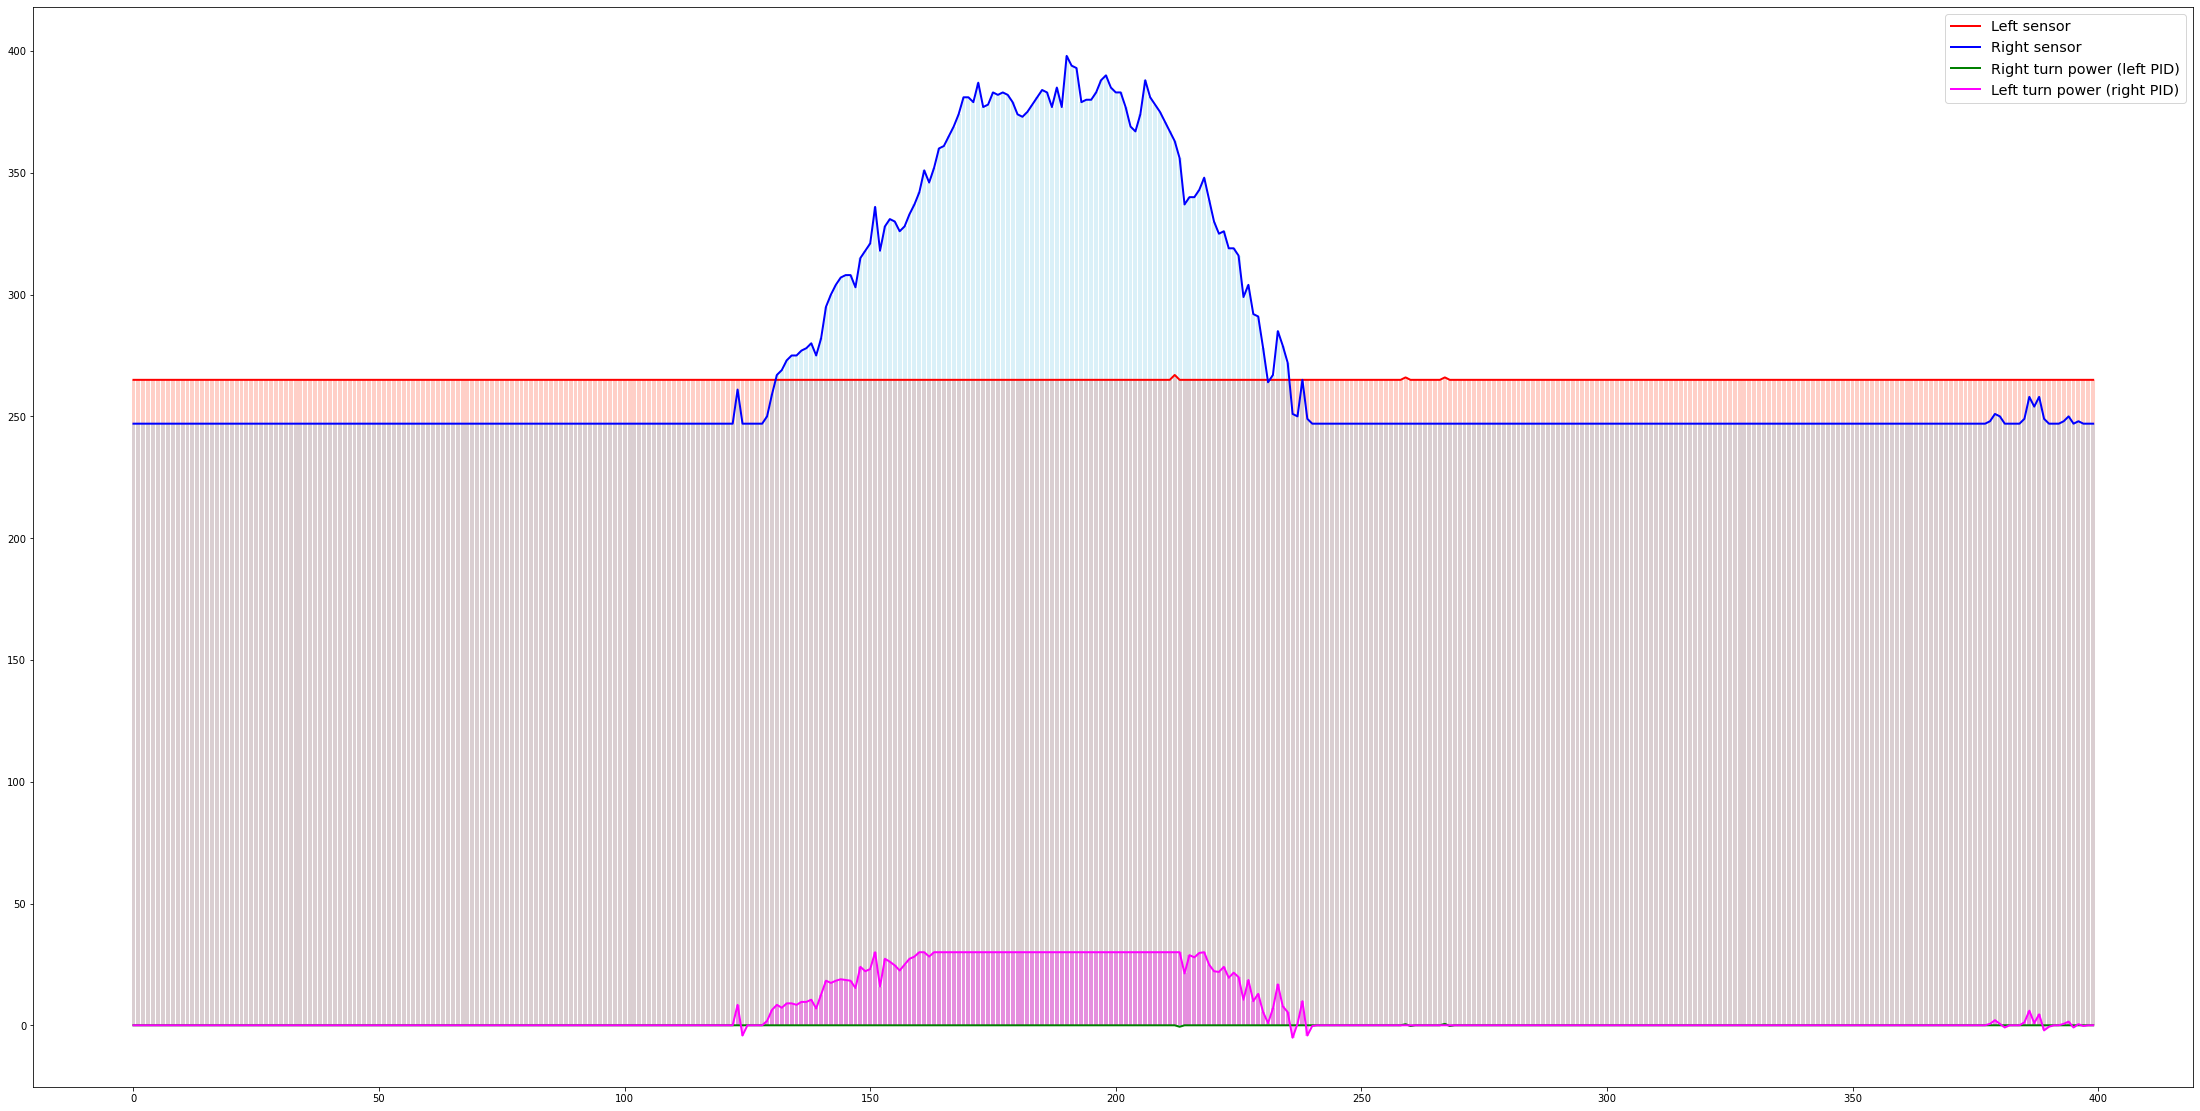

In [13]:
for i in range(0, len(left_pid_out),1):
    if left_pid_out[i] > 0 and right_pid_out[i]>0:
        if left_pid_out[i] > right_pid_out[i]:
            right_pid_out[i] = 0
        elif right_pid_out[i] > left_pid_out[i]:
            left_pid_out[i] = 0  

range_len = 400
start = 1400
end = start + range_len
fig = plt.figure(figsize=(30, 15))
ax = fig.add_axes([0,0,1,1])

ax.plot(sensor1[start:end], linewidth=2.0, color = 'red', label='Left sensor')
ax.bar(np.arange(0,range_len,1), sensor1[start:end], color = 'tomato', alpha = 0.3)
ax.plot(sensor3[start:end], linewidth=2.0, color = 'blue', label = 'Right sensor')
ax.bar(np.arange(0,range_len,1), sensor3[start:end], color = 'skyblue', alpha = 0.3)

ax.plot(left_pid_out[start:end], linewidth=2.0, color = 'green', label = 'Right turn power (left PID)')
ax.bar(np.arange(0,range_len,1), left_pid_out[start:end], alpha = 0.3, color = 'springgreen')
ax.plot(right_pid_out[start:end], linewidth=2.0, color = 'magenta', label = 'Left turn power (right PID)')
ax.bar(np.arange(0,range_len,1), right_pid_out[start:end], alpha = 0.3, color = 'magenta')
ax.legend(fontsize = 'x-large')


* Кажестся, что при сильном отлонении слишком медленно наращивается воздействие - добавить константу
* Надо сделать калибровку датчиков по формуле (current-min)/(max-min)

Оказалось, что для устранения задержки реакции на больших углах отклонения необходимо установить минимальную величину управляющего сигнала. После установки установки минимального значения рывным пяти удалось получить стабильное прохождение на 14 скорости. При этом пришлось увеличить KD до 1 для гашения колебаний на прямой. В целом при использовании минимального значения управляющего воздествия улучшилось прохождние кривых, но ухудшилось прохождение прямых.

* Нужно подумать как убрать минимальное значение на малых отклонениях для прохождения прямой
* Увеличение SLEEP_TIME до 1 ms ведет к деградации и вылетам